<a href="https://colab.research.google.com/github/ridwanabdiansah29/Submission-Dicoding-Image-Classification-Model-Deployment/blob/main/RIDWAN_ABDIANSAH_M193X0386_M06_IMAGECLASSIFICATIONDEPLOYMENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Ridwan Abdiansah
##M193X0386
##M06
##Submission Image Deployment

## Import Library

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [3]:
import zipfile,os
local_zip = '/tmp/flower.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [4]:
trainings_datagen = ImageDataGenerator(
    rescale = 1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    horizontal_flip=True,
    shear_range=0.2,
    rotation_range=0.2,
    fill_mode='nearest',
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2
)

In [5]:
base_dir = '/tmp/flowers'
train_generator = trainings_datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    seed=42,
    target_size=(150,150),
    shuffle=True,
    subset='training'
)
validation_generator = val_datagen.flow_from_directory(
    base_dir,
    seed=42,
    class_mode='categorical',
    target_size=(150,150),
    subset='validation'
)

Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


##Base Model

In [8]:
base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False
)

9406464/9406464 [==============================] - 0s 0us/step


In [9]:
base_model.trainable = True

In [10]:
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [13]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.92):
      if(logs.get('accuracy')>0.92):
        print("Traning akan Berhenti Ketika Akurasi Model Sudah Lebih Dari 96%")
        self.model.stop_training=True

callbacks = myCallback()

In [14]:
batch_size=64

history=model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[callbacks]
)

Epoch 1/25
109/109 [==============================] - 370s 3s/step - loss: 1.3454 - accuracy: 0.4458 - val_loss: 0.9046 - val_accuracy: 0.6337
Epoch 2/25
109/109 [==============================] - 361s 3s/step - loss: 0.8048 - accuracy: 0.6980 - val_loss: 0.9583 - val_accuracy: 0.7279
Epoch 3/25
109/109 [==============================] - 357s 3s/step - loss: 0.5891 - accuracy: 0.7935 - val_loss: 0.5854 - val_accuracy: 0.8244
Epoch 4/25
109/109 [==============================] - 361s 3s/step - loss: 0.4927 - accuracy: 0.8285 - val_loss: 0.5132 - val_accuracy: 0.8593
Epoch 5/25
109/109 [==============================] - 361s 3s/step - loss: 0.4382 - accuracy: 0.8510 - val_loss: 0.6192 - val_accuracy: 0.8384
Epoch 6/25
109/109 [==============================] - 360s 3s/step - loss: 0.3773 - accuracy: 0.8719 - val_loss: 0.6026 - val_accuracy: 0.8616
Epoch 7/25
109/109 [==============================] - 359s 3s/step - loss: 0.3543 - accuracy: 0.8794 - val_loss: 0.4746 - val_accuracy: 0.8826

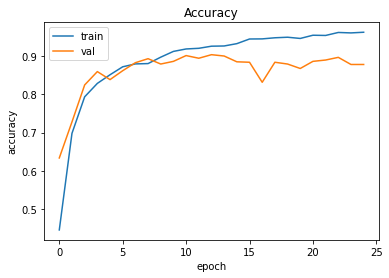

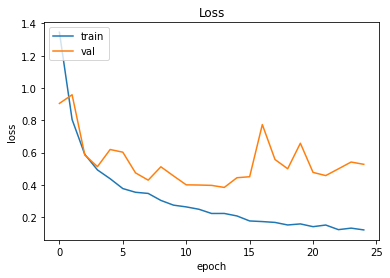

In [15]:
# Mengambil Nilai Accuracy 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
# Menyimpan model dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)
 
# Convert SavedModel menjadi format .tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('flower.tflite')
tflite_model_file.write_bytes(tflite_model)

9663020

In [17]:
from google.colab import files

# Download the flower model
files.download('/content/flower.tflite')

print('`flower.tflite` has been downloaded')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

`flower.tflite` has been downloaded
